In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score

import matplotlib.pyplot as plt
import xgboost

import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

from sklearn import tree
from sklearn.tree import plot_tree as plot_tree

from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score,make_scorer
import optuna

C:\Users\PartZ\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preprocess

In [5]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.dropna()
y = train["electricity_consumption_kWh"].to_numpy()
train = train.drop("electricity_consumption_kWh" , axis = 1)
x_test = test.to_numpy()
x_train, x_valid, y_train, y_valid = train_test_split(train, y, test_size=0.2)
x_train = x_train.to_numpy()
x_valid = x_valid.to_numpy()
x_train[:,0]

array([120.7 , 117.94,  72.02,  55.38, 169.76,  70.27, 160.79,  55.14,
        79.87,  67.55,  44.25,  72.25, 160.63,  90.5 ,  47.4 ,  93.98,
        44.81, 143.69,  74.58, 136.43, 133.83,  92.45, 147.27, 143.29,
        77.65,  84.57, 116.63,  40.84,  98.73,  61.14, 108.86, 137.13,
        84.51,  70.87,  68.48, 134.16, 159.46,  55.23, 112.81, 131.52,
       148.23, 134.99, 150.63, 121.86, 148.36,  78.75, 162.06,  54.64,
       136.07,  89.38, 134.16,  68.85, 151.63, 155.29,  62.8 , 153.52,
       128.28, 168.15, 162.48,  56.99,  62.77, 110.82,  93.99, 158.55,
       132.92, 142.2 ,  50.09,  43.78,  81.19,  94.7 , 137.73, 141.89,
        50.39,  45.34, 135.86, 153.99, 143.49, 106.06, 143.2 , 127.38,
       103.14,  85.65, 147.13,  86.6 , 116.12, 138.72, 136.06, 147.56,
        97.88, 119.3 ,  75.25,  82.23,  77.04,  64.96, 166.11, 161.03,
       149.78, 168.55, 164.58, 133.65, 134.43, 160.81,  71.15, 125.91,
       112.89, 127.68,  46.65,  71.52, 104.89,  75.64, 128.8 , 142.18,
      

In [ ]:
train

# Visualization

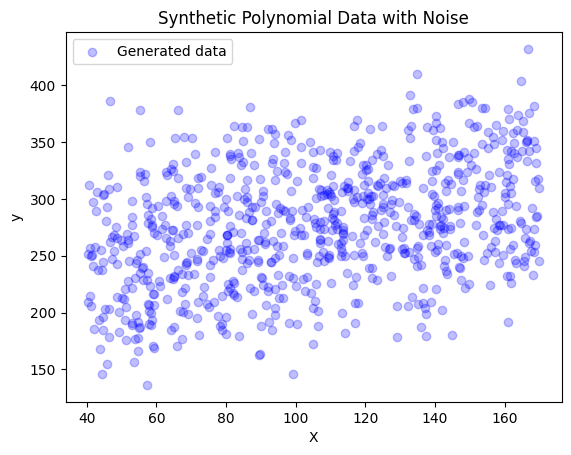

In [4]:
plt.scatter(x_train[:,0], y_train, color='b', alpha=0.25, label='Generated data')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Synthetic Polynomial Data with Noise')
plt.legend()
plt.show()

# Model Training

In [30]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': 42
    }
    
    model = xgboost.XGBRegressor(**params)
    
    r2 = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring=make_scorer(r2_score)).mean()
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best R2 Score:", study.best_value)
print("Best Parameters:", study.best_params)


xgb_model = xgboost.XGBRegressor(**study.best_params)

xgb_model.fit(x_train, y_train)

y_pred = xgb_model.predict(x_valid)
print("Test R2 Score:", r2_score(y_valid, y_pred))

Best R2 Score: 0.7736628986313004
Best Parameters: {'n_estimators': 455, 'max_depth': 3, 'learning_rate': 0.015162997800277887, 'subsample': 0.8243872718275826, 'colsample_bytree': 0.768994599808784, 'gamma': 1.6072766558752853, 'reg_alpha': 4.48296643499918, 'reg_lambda': 4.501457537206997}
Test R2 Score: 0.7262659402099039


In [36]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
def objective(trial):
    degree = trial.suggest_int("degree", 1, 3)
    use_scaler = trial.suggest_categorical("use_scaler", [True, False])
    
    steps = []
    if use_scaler:
        steps.append(("scaler", StandardScaler()))
    
    if degree > 1:
        steps.append(("poly", PolynomialFeatures(degree=degree, include_bias=False)))
    
    steps.append(("lr", LinearRegression()))
    
    pipeline = Pipeline(steps)

    r2 = cross_val_score(pipeline, x_train, y_train, cv=5, scoring=make_scorer(r2_score)).mean()
    return r2

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best R2 Score:", study.best_value)
print("Best Parameters:", study.best_params)



[I 2025-09-21 22:58:38,888] A new study created in memory with name: no-name-643c23fc-7808-49ca-9e08-99ce6d857ca3
[I 2025-09-21 22:58:38,955] Trial 0 finished with value: 0.7823685091730326 and parameters: {'degree': 1, 'use_scaler': True}. Best is trial 0 with value: 0.7823685091730326.
[I 2025-09-21 22:58:39,008] Trial 1 finished with value: 0.7685663840918032 and parameters: {'degree': 3, 'use_scaler': True}. Best is trial 0 with value: 0.7823685091730326.
[I 2025-09-21 22:58:39,024] Trial 2 finished with value: 0.7823685091730326 and parameters: {'degree': 1, 'use_scaler': True}. Best is trial 0 with value: 0.7823685091730326.
[I 2025-09-21 22:58:39,045] Trial 3 finished with value: 0.7680839337012291 and parameters: {'degree': 3, 'use_scaler': False}. Best is trial 0 with value: 0.7823685091730326.
[I 2025-09-21 22:58:39,067] Trial 4 finished with value: 0.7773112564365819 and parameters: {'degree': 2, 'use_scaler': True}. Best is trial 0 with value: 0.7823685091730326.
[I 2025-09

Best R2 Score: 0.7823685091730327
Best Parameters: {'degree': 1, 'use_scaler': False}


In [33]:
predict = xgb_model.predict(x_test)
submission = pd.DataFrame(predict , columns=['electricity_consumption_kWh'])
submission

,electricity_consumption_kWh
0,308.132385
1,253.006409
2,352.916168
3,250.152863
4,318.599579
...,...
519,249.387299
520,308.068359
521,291.340302
522,321.351898
